In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from psmpy import PsmPy

from utils import read_pkl, write_pkl, plot_demography, get_ascii, lemmatize

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from gensim.models import Word2Vec

In [3]:
df = pd.read_csv('./data/dataframe.csv', index_col=0)
df['Target'] = df.ICD9.apply(lambda x: 1 if x in ('43401','43490','43491') else 0)
df

,Patient_ID,Gender,Age,Admission_ID,Text,ICD9,Priority,Target
0,32191,M,47.94,2020030048,"Violenza domestica, aggerito con oggetto contu...",33811,2.0,0
1,107975,F,81.80,2020030049,Riferito dalla figlia rallentamento ideomotori...,78079,2.0,0
2,1794053,F,19.67,2020030050,Riferito abuso alcolico con superalcolici. In ...,9800,3.0,0
3,1789983,M,46.73,2020030051,Algia mascellare dx e cefalea in recente inter...,30789,2.0,0
4,384942,M,21.98,2020030052,Riferisce sensazione di cardiopalmo dalle h2 i...,7851,3.0,0
...,...,...,...,...,...,...,...,...
305222,1611913,M,60.89,2019008941,giunge invaiato dal 118 con mdb per riferita c...,34500,2.0,0
305223,388700,F,83.84,2019008942,"riferisce caduta 10gg fa, esegue rx mano con d...",81500,3.0,0
305224,1958515,F,48.14,2019008945,giunge per presenza di corpo estraneo occhio d...,37200,3.0,0
305225,20143,M,27.86,2019008947,"ieri, dutrante attivita lavoratriva, riferisce...",9300,3.0,0


# Propensity Score Matching

In [3]:
df_propensity = df.loc[:, ['Gender','Age','Target']].copy()
df_propensity.Age = df_propensity.Age.fillna(60)
df_propensity.Gender = df_propensity.Gender.replace({'M': 0, 'F': 1}).fillna(0.0)
df_propensity = df_propensity.rename_axis('row_id').reset_index()
df_propensity.head()

,row_id,Gender,Age,Target
0,0,0.0,47.94,0
1,1,1.0,81.80,0
2,2,1.0,19.67,0
3,3,0.0,46.73,0
4,4,0.0,21.98,0


In [4]:
df_propensity.groupby('Target').agg({'Gender': 'mean', 'Age': 'mean', 'row_id': 'count'}).T

Target,0,1
Gender,0.487440,0.470679
Age,55.109624,75.044815
row_id,304579.000000,648.000000


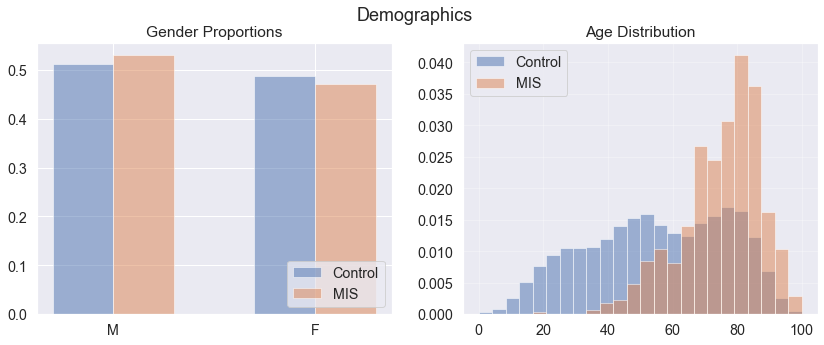

In [5]:
f, axs = plot_demography(df_propensity)

In [6]:
psm = PsmPy(df_propensity, treatment='Target', indx='row_id')

In [7]:
psm.logistic_ps(balance=False)
psm.knn_matched_12n(matcher='propensity_logit', how_many=100)
psm.predicted_data

,row_id,Gender,Age,propensity_score,propensity_logit,Target
0,0,0.0,47.94,0.000962,-6.945670,0
1,1,1.0,81.80,0.004410,-5.419409,0
2,2,1.0,19.67,0.000168,-8.689323,0
3,3,0.0,46.73,0.000903,-7.009352,0
4,4,0.0,21.98,0.000246,-8.311949,0
...,...,...,...,...,...,...
305222,302238,1.0,67.64,0.002098,-6.164653,1
305223,302681,0.0,77.07,0.004440,-5.412552,1
305224,303127,1.0,88.13,0.006143,-5.086260,1
305225,304940,1.0,68.55,0.002201,-6.116760,1


In [8]:
prop_idx = psm.matched_ids.values.flatten()
df_matched = df_propensity.loc[prop_idx, :]
df_matched.head()

,row_id,Gender,Age,Target
253,253,0.0,79.41,1
89580,89580,0.0,79.41,0
125627,125627,0.0,41.75,0
141301,141301,0.0,78.67,0
72650,72650,0.0,80.56,0


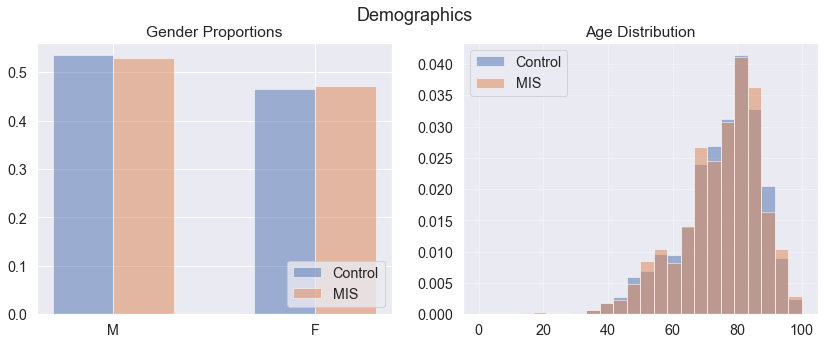

In [9]:
f, axs = plot_demography(df_matched)

# Text Preprocessing

In [4]:
df['Processed_Text'] = df.Text.apply(get_ascii)
df.Processed_Text = df.Processed_Text.str.replace(r'\d+','')
df.head()

,Patient_ID,Gender,Age,Admission_ID,Text,ICD9,Priority,Target,Processed_Text
0,32191,M,47.94,2020030048,"Violenza domestica, aggerito con oggetto contu...",33811,2.0,0,"Violenza domestica, aggerito con oggetto contu..."
1,107975,F,81.80,2020030049,Riferito dalla figlia rallentamento ideomotori...,78079,2.0,0,Riferito dalla figlia rallentamento ideomotori...
2,1794053,F,19.67,2020030050,Riferito abuso alcolico con superalcolici. In ...,9800,3.0,0,Riferito abuso alcolico con superalcolici. In ...
3,1789983,M,46.73,2020030051,Algia mascellare dx e cefalea in recente inter...,30789,2.0,0,Algia mascellare dx e cefalea in recente inter...
4,384942,M,21.98,2020030052,Riferisce sensazione di cardiopalmo dalle h2 i...,7851,3.0,0,Riferisce sensazione di cardiopalmo dalle h in...


In [5]:
df['Lemmatized_Text'] = lemmatize(df.Processed_Text)
df.loc[:, ['Processed_Text','Lemmatized_Text']]

,Processed_Text,Lemmatized_Text
0,"Violenza domestica, aggerito con oggetto contu...","violenza domestico , aggerito con oggetto cont..."
1,Riferito dalla figlia rallentamento ideomotori...,riferire dalla figlia rallentamento ideomotori...
2,Riferito abuso alcolico con superalcolici. In ...,riferire abuso alcolico con superalcolico . in...
3,Algia mascellare dx e cefalea in recente inter...,Algia mascellare dx e cefalea in recente inter...
4,Riferisce sensazione di cardiopalmo dalle h in...,riferire sensazione di cardiopalmo dalla h in ...
...,...,...
305222,giunge invaiato dal con mdb per riferita cris...,giungere invaiato dal con mdb per riferire cri...
305223,"riferisce caduta gg fa, esegue rx mano con dia...","riferire caduta gg fa , eseguire rx mano con d..."
305224,giunge per presenza di corpo estraneo occhio d...,giungere per presenza di corpo estraneo occhio...
305225,"ieri, dutrante attivita lavoratriva, riferisce...","ieri , dutrante attivita lavoratriva , riferir..."


In [6]:
tokenizer = RegexpTokenizer(r'\w+')

df['Tokens'] = df.Lemmatized_Text.str.lower().apply(lambda x: tokenizer.tokenize(x))
df.Tokens

0         [violenza, domestico, aggerito, con, oggetto, ...
1         [riferire, dalla, figlia, rallentamento, ideom...
2         [riferire, abuso, alcolico, con, superalcolico...
3         [algia, mascellare, dx, e, cefalea, in, recent...
4         [riferire, sensazione, di, cardiopalmo, dalla,...
                                ...                        
305222    [giungere, invaiato, dal, con, mdb, per, rifer...
305223    [riferire, caduta, gg, fa, eseguire, rx, mano,...
305224    [giungere, per, presenza, di, corpo, estraneo,...
305225    [ieri, dutrante, attivita, lavoratriva, riferi...
305226    [riferire, da, qualche, giorno, algia, ad, ent...
Name: Tokens, Length: 305227, dtype: object

In [7]:
negs = [
    r'(\bn[oe](n|ga|gativ[aeio](ta)?)?\b)',
    r'(\bmai\b|\bnessu\w*|\bsenza\b|\bassenza\b)',
]

neg_words = []
for neg in negs:
    neg_words.extend(df.Tokens.str.extract(neg).iloc[:,0].value_counts().index)

stop = set(stopwords.words("italian"))
for w in neg_words:
    try:
        stop.remove(w)
    except:
        pass
    
df.Tokens = df.Tokens.apply(lambda doc: [w for w in doc if w not in stop])
df.Tokens

0         [violenza, domestico, aggerito, oggetto, contu...
1         [riferire, figlia, rallentamento, ideomotorio,...
2         [riferire, abuso, alcolico, superalcolico, tri...
3         [algia, mascellare, dx, cefalea, recente, inte...
4         [riferire, sensazione, cardiopalmo, h, assenza...
                                ...                        
305222    [giungere, invaiato, mdb, riferire, crisi, epi...
305223    [riferire, caduta, gg, fa, eseguire, rx, mano,...
305224    [giungere, presenza, corpo, estraneo, occhio, ...
305225    [ieri, dutrante, attivita, lavoratriva, riferi...
305226    [riferire, qualche, giorno, algia, entrambi, o...
Name: Tokens, Length: 305227, dtype: object

In [8]:
w2v = Word2Vec(
    sentences=df.Tokens, 
    vector_size=300, 
    window=5, 
    min_count=1, 
    workers=4,
    compute_loss=True,
    epochs=20,
    negative=10,
)

w2v.save('./results/w2v.mdl')

In [10]:
df['Embedding'] = df.Tokens.apply(lambda x: np.mean([w2v.wv[token] for token in x], axis=0))
cols = ['Embedding','Target','Priority']
write_pkl(df.loc[prop_idx, cols], './results/processed_df.pkl')